# Comparison of weight trajectories through loss landscape in BP, BTSP, and Hebbian networks

## 0. Setup

In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

input_size = 21
dataset = torch.eye(input_size) #each row is a different pattern
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                        shuffle=True, 
                        generator=data_generator)

test_dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                             batch_size = 21)
epochs=300
seed=42

weight_seeds = [65793, 65794, 65795, 65796, 65797] 
data_seeds = [257, 258, 259, 260, 261]

model_nr = 0
seed = weight_seeds[model_nr]
data_seed = data_seeds[model_nr]

## 1. Create networks

### Dale's Law Backprop (1 inh)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

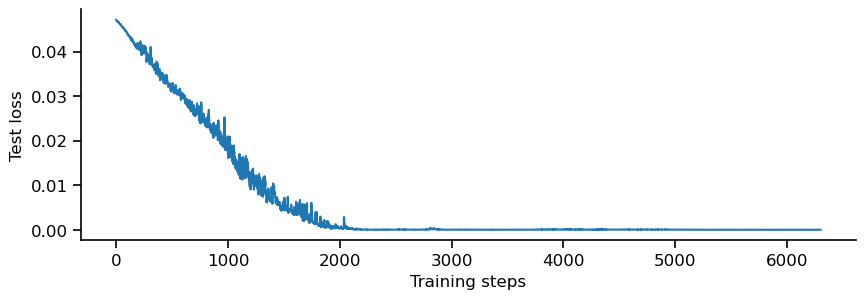

In [2]:
network_config = ut.read_from_yaml('../config/loss_landscape_analysis/EIANN_1_hidden_backprop_1_inh_softplus_SGD_config_B.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

data_generator.manual_seed(data_seed)
bpDale_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

for layer in bpDale_network: #swap to ReLU activation to make loss comparable across networks
    for population in layer:
        population.activation = torch.nn.ReLU()

bpDale_network.reset_history()
pt.plot_test_loss_history(bpDale_network, test_dataloader, store_history=True)

### BTSP (1 inh)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

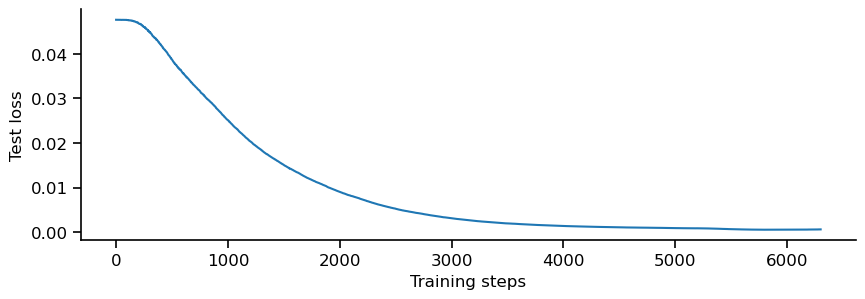

In [3]:
# network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221104_EIANN_1_hidden_BTSP_config_B.yaml')
network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221107_EIANN_1_hidden_BTSP_config_C.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

data_generator.manual_seed(data_seed)
btsp_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

btsp_network.reset_history()
pt.plot_test_loss_history(btsp_network, test_dataloader, store_history=True)

In [4]:
# # Remove BTSP-specific parameters (Dend_I)
# bp_dict_keys = bpDale_network.state_dict().keys()
# for i,state_dict in enumerate(btsp_network.param_history):
#     state_dict_subset = {key: state_dict[key] for key in bp_dict_keys}
#     btsp_network.param_history[i] = state_dict_subset
    
# flat_param_hist_btsp,_ = pt.get_flat_param_history(btsp_network.param_history)
# pt.plot_param_history_PCs(flat_param_hist_btsp)

In [5]:
# weights_dict1 = {}
# btsp_network.name='btsp'
# bpDale_network.name='bpDale'

# for network in [btsp_network,bpDale_network]:
#     all_weights = []
#     for param_name in network.param_history[-1]:
#         if 'weight' in param_name and 'FBI' not in param_name:
#             flat_weights = network.param_history[-1][param_name].flatten()
#             all_weights.append(flat_weights)
#     weights_dict1[network.name] = torch.cat(all_weights)
    
# plt.hist(weights_dict1['btsp'],100,color='r',alpha=0.5,label='btsp')
# plt.hist(weights_dict1['bpDale'],100,color='b',alpha=0.5,label='BP')
# plt.title('Weight distributions')
# plt.legend()
# plt.ylim(top=50)
# plt.show()

## 2. Analyze Loss Landscape

In [6]:
from EIANN.plot import *

all_networks = {'bpDale': bpDale_network, 
                'BTSP': btsp_network}

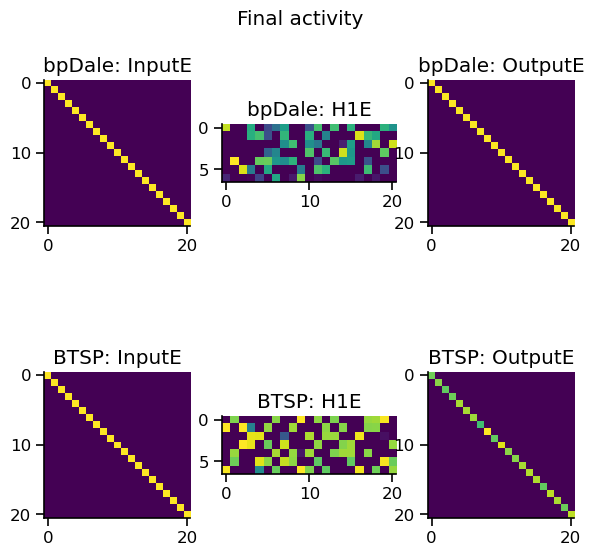

In [7]:
fig = plt.figure(figsize=(6, 10))
axes = gs.GridSpec(nrows=3, ncols=3,
                   left=0.05, right=0.98,
                   top=0.83, bottom=0.1,
                   wspace=0.1, hspace=1)

for row, (name,network) in enumerate(all_networks.items()):
    populations = [network.Input.E, network.H1.E, network.Output.E]
    for col, population in enumerate(populations):
        final_activity = population.activity_history[-1,-1].T
        ax = fig.add_subplot(axes[row, col])
        im = ax.imshow(final_activity)
        ax.set_title(f'{name}: {population.fullname}')
        
fig.suptitle('Final activity',y=0.9)
plt.show()

fig.savefig('Final_activity.svg',dpi=300)

### Re-run Dale's BP with same init as BTSP

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

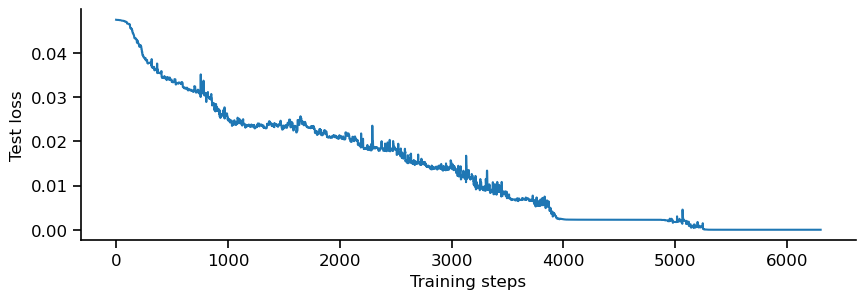

In [8]:
network_config = ut.read_from_yaml('../config/loss_landscape_analysis/EIANN_1_hidden_backprop_1_inh_softplus_SGD_config_B.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']
training_kwargs['learning_rate'] = 14

bpDale_network2 = Network(layer_config, projection_config, seed=seed, **training_kwargs)

# # Initialize backprop net with same weights as BTSP init
# btsp_init = btsp_network.param_history[0]
# bpDale_init = bpDale_network2.state_dict()
# initial_state = {key: btsp_init[key] for key in bpDale_init}
# bpDale_network2.load_state_dict(initial_state)

# Initialize backprop net with same weights as BTSP init: only E weights
btsp_init = btsp_network.param_history[0]
bpDale_init = bpDale_network2.state_dict()
initial_state = {key: btsp_init[key] for key in bpDale_init if 'FBI' not in key}
for key in initial_state:
    bpDale_init[key] = initial_state[key]    
bpDale_init['module_dict.H1FBI_H1E.weight'] = btsp_init['module_dict.H1FBI_H1E.weight']
bpDale_init['module_dict.OutputFBI_OutputE.weight'] = btsp_init['module_dict.OutputFBI_OutputE.weight']
bpDale_init['parameter_dict.H1FBI_bias'] = btsp_init['parameter_dict.H1FBI_bias']
bpDale_init['parameter_dict.OutputFBI_bias'] = btsp_init['parameter_dict.OutputFBI_bias']
bpDale_init['module_dict.H1E_H1FBI.weight'] = btsp_init['module_dict.H1E_H1FBI.weight']
bpDale_init['module_dict.OutputE_OutputFBI.weight'] = (1*btsp_init['module_dict.OutputE_OutputFBI.weight']+9*bpDale_init['module_dict.OutputE_OutputFBI.weight'])/10

bpDale_network2.load_state_dict(bpDale_init)

data_generator.manual_seed(data_seed)
bpDale_network2.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

for layer in bpDale_network2: #swap to ReLU activation to make loss comparable across networks
    for population in layer:
        population.activation = torch.nn.ReLU()

bpDale_network2.reset_history()
pt.plot_test_loss_history(bpDale_network2, test_dataloader, store_history=True)


In [9]:
# for i in bpDale_network2.state_dict():
#     print(i)

In [10]:
# # Remove BTSP-specific parameters (Dend_I)
# bp_dict_keys = bpDale_network.state_dict().keys()
# for i,state_dict in enumerate(btsp_network.param_history):
#     state_dict_subset = {key: state_dict[key] for key in bp_dict_keys}
#     btsp_network.param_history[i] = state_dict_subset
    
# bpDale_network2.name = "Dale's BP"
# btsp_network.name = 'BTSP'

# pt.plot_loss_landscape(test_dataloader, bpDale_network2, btsp_network, num_points=100, extension=0.2, vmax=1.)

### Re-run BTSP with same init as Dale's BP

In [11]:
# # network_config = ut.read_from_yaml('../config/loss_landscape_analysis/EIANN_1_hidden_backprop_1_inh_softplus_SGD_config_B.yaml')
# network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221107_EIANN_1_hidden_BTSP_config_C.yaml')

# layer_config = network_config['layer_config']
# projection_config = network_config['projection_config']
# training_kwargs = network_config['training_kwargs']

# btsp_network2 = Network(layer_config, projection_config, seed=seed, **training_kwargs)

# # Initialize backprop net with same weights as BTSP init
# bpDale_init = bpDale_network.param_history[0]
# btsp_init = btsp_network2.state_dict()
# initial_state = {key: bpDale_init[key] for key in btsp_init if 'FBI' not in key}
# for key in initial_state:
#     btsp_init[key] = initial_state[key]
# btsp_network2.load_state_dict(btsp_init)

# data_generator.manual_seed(data_seed)
# btsp_network2.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

# for layer in btsp_network2: #swap to ReLU activation to make loss comparable across networks
#     for population in layer:
#         population.activation = torch.nn.ReLU()

# btsp_network2.reset_history()
# pt.plot_test_loss_history(btsp_network2, test_dataloader, store_history=True)


In [12]:
# # Remove BTSP-specific parameters (Dend_I)
# bp_dict_keys = bpDale_network.state_dict().keys()
# for i,state_dict in enumerate(btsp_network2.param_history):
#     state_dict_subset = {key: state_dict[key] for key in bp_dict_keys}
#     btsp_network2.param_history[i] = state_dict_subset
    
# bpDale_network.name = "Dale's BP"
# btsp_network2.name = 'BTSP'

# pt.plot_loss_landscape(test_dataloader, bpDale_network, btsp_network2, num_points=50, extension=0.1, vmax=1.)

### Re-run both networks with intermediate init

In [13]:
# initial_state_btsp = btsp_network.param_history[0]
# initial_state_bpDale = bpDale_network2.param_history[0]

# initial_state_bpDale = {key: (initial_state_btsp[key]+initial_state_bpDale[key])/2 for key in bpDale_network2.state_dict()}

# for key in initial_state_bpDale:
#     if key in initial_state_btsp:
#         initial_state_btsp[key] = initial_state_bpDale[key]


In [14]:
# # Dale's BP

# network_config = ut.read_from_yaml('../config/loss_landscape_analysis/EIANN_1_hidden_backprop_1_inh_softplus_SGD_config_B.yaml')
# layer_config = network_config['layer_config']
# projection_config = network_config['projection_config']
# training_kwargs = network_config['training_kwargs']

# bpDale_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)
# bpDale_network.load_state_dict(initial_state_bpDale)

# data_generator.manual_seed(data_seed)
# bpDale_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

# for layer in bpDale_network: #swap to ReLU activation to make loss comparable across networks
#     for population in layer:
#         population.activation = torch.nn.ReLU()

# bpDale_network.reset_history()
# pt.plot_test_loss_history(bpDale_network, test_dataloader, store_history=True)

In [15]:
# # BTSP

# # network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221104_EIANN_1_hidden_BTSP_config_B.yaml')
# network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221107_EIANN_1_hidden_BTSP_config_C.yaml')
# layer_config = network_config['layer_config']
# projection_config = network_config['projection_config']
# training_kwargs = network_config['training_kwargs']

# btsp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)
# btsp_network.load_state_dict(initial_state_btsp)

# data_generator.manual_seed(data_seed)
# btsp_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

# btsp_network.reset_history()
# pt.plot_test_loss_history(btsp_network, test_dataloader, store_history=True)

### Generate Loss Landscape plot

In [16]:
# Remove BTSP-specific parameters (Dend_I)
bp_dict_keys = bpDale_network.state_dict().keys()
for i,state_dict in enumerate(btsp_network.param_history):
    state_dict_subset = {key: state_dict[key] for key in bp_dict_keys}
    btsp_network.param_history[i] = state_dict_subset

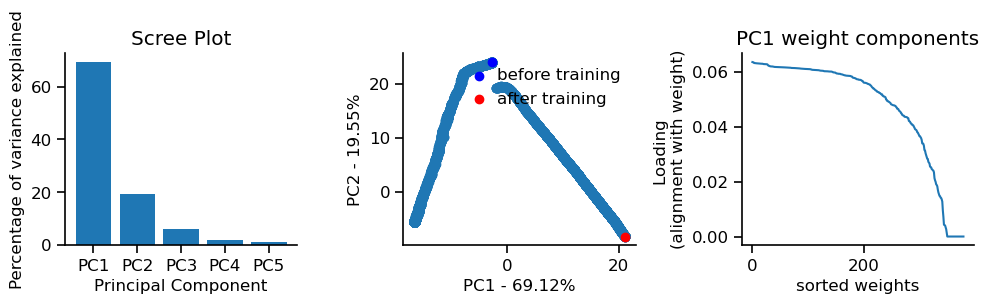

In [17]:
flat_param_hist_bpDale,_ = pt.get_flat_param_history(bpDale_network.param_history)
flat_param_hist_btsp,_ = pt.get_flat_param_history(btsp_network.param_history)

combined_param_history = torch.cat([flat_param_hist_bpDale, flat_param_hist_btsp])

fig,sorted_loadings = pt.plot_param_history_PCs(combined_param_history)

fig.savefig('figures/PCA_summary_combined.svg',dpi=300)
fig.savefig('figures/PCA_summary_combined.png',dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

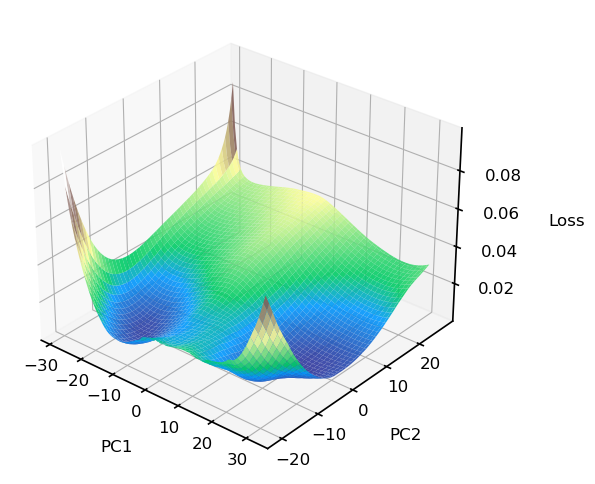

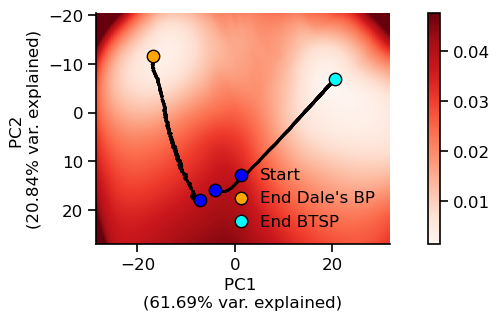

In [24]:
bpDale_network2.name = "Dale's BP"
btsp_network.name = 'BTSP'

fig = pt.plot_loss_landscape(test_dataloader, bpDale_network2, btsp_network, num_points=100, extension=0.3, vmax=1)

In [25]:
fig.savefig(f'figures/loss_landscape_{model_nr}.svg',dpi=300)
fig.savefig(f'figures/loss_landscape_{model_nr}.png',dpi=300)

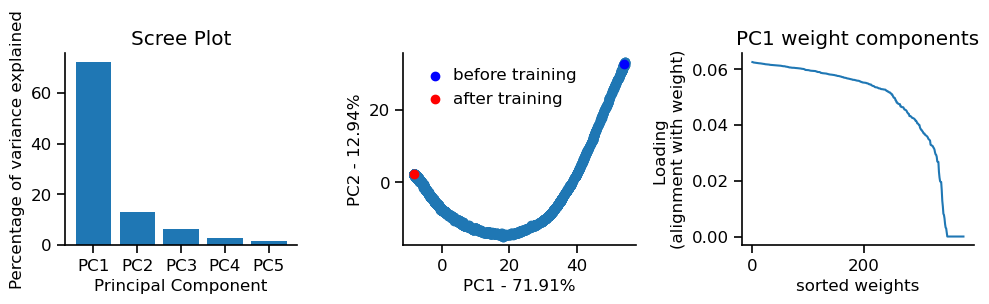

In [26]:
fig, sorted_loadings_bp = pt.plot_param_history_PCs(flat_param_hist_bpDale)
fig.savefig('figures/PCA_summary_Dale.svg',dpi=300)
fig.savefig('figures/PCA_summary_Dale.png',dpi=300)

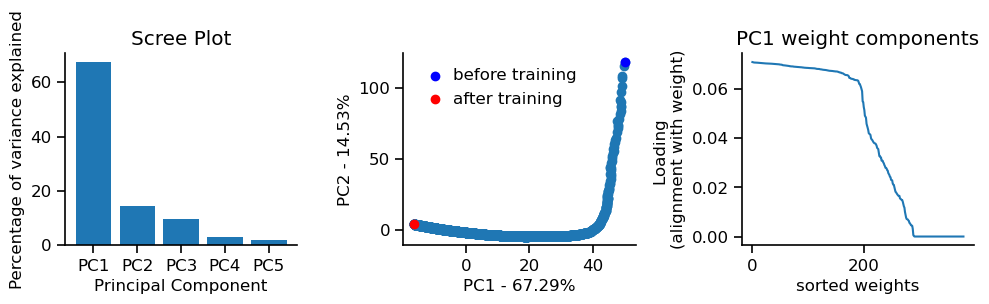

In [27]:
fig, sorted_loadings_btsp = pt.plot_param_history_PCs(flat_param_hist_btsp)
fig.savefig('figures/PCA_summary_btsp.svg',dpi=300)
fig.savefig('figures/PCA_summary_btsp.png',dpi=300)